# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.




<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

### ToDo 1.1
Now, I'll read the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>



In [3]:
df = pd.read_csv('D:/Machine_Learning/FWD/Advanced\Analyzing AB_Test_Results/analyzeabtestresults-2/AnalyzeABTestResults 2/ab_data.csv')

**b.** Finding the number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
len(df['user_id'].unique())

290584

**d.** The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df[(df['landing_page'] =='new_page') & (df['group'] == 'control')].count()

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

In [8]:
df[(df['landing_page'] =='old_page') & (df['group'] == 'treatment')].count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

**f.** Do any of the rows have missing values?

In [9]:
df.isnull().head()

,user_id,timestamp,group,landing_page,converted
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



**a.** Now I'll use the dataset create a new dataset that meets the specifications from the above info.  And store my new dataframe in **df2**.

In [10]:
# Removing the inaccurate rows, and storing the result in a new dataframe df2
var = df[(df['landing_page'] =='new_page') & (df['group'] == 'control')|(df['landing_page'] =='old_page') & (df['group'] == 'treatment')].index
df2 = df.drop(index = var)
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [11]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3
Answering the questions

**a.** How many unique **user_id**s are in **df2**?

In [12]:
len(df2['user_id'].unique())

290584

**b.** There is one **user_id** repeated in **df2**

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Removing **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Removing one of the rows with a duplicate user_id..
df2.drop(index = 1899,inplace=True)

# Checking again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

> The probability  I'll compute represents the overall "converted" success rate in the population and I may call it $p_{population}$.



In [16]:
p_population = df2['converted'].mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_group = df2[df2['group'] == 'control']
control_group['converted'].mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_group = df2[df2['group'] == 'treatment']
treatment_group['converted'].mean()

0.11880806551510564

>**Tip**: The probabilities I've computed in the points (b). and (c). above can also be treated as conversion rate. 
I'll calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups.  

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_group['converted'].mean() - control_group['converted'].mean() 
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page'] == 'new_page'].count()/df2.count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

**e.** Considering my results from parts (a) through (d) above, I'll explain below whether the new `treatment` group users lead to more conversions.

- The Treatment group convertion rate is 0.1189 while the Control group is 0.1204 so apparently there is no huge difference between them so we can prefer on to another.
- We may discover further information about this in the next sections but so far we don't have enough.


<a id='ab_test'></a>
## Part II - A/B Test


### ToDo 2.1
For now, I'll consider that I need to make the decision just based on all the data provided.  



**$H_0$** : P_new <= P_old Convertion rate for the old page is greater than or equal to the new page                                                       
**$H_1$** : P_new > P_old Convertion rate for the new page is greater than the old page

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assuming that $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [23]:
new_page = df2[df2['landing_page'] == 'new_page'].shape[0]
new_page

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
old_page = df2[df2['landing_page'] == 'old_page'].shape[0]
old_page

145274

**e. Simulating Sample for the `treatment` Group**<br> 
Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [25]:
# Simulate a Sample for the treatment Group
new_page_converted =  np.random.choice([0,1], size=new_page, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.881061179547175

**f. Simulating Sample for the `control` Group** <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis.

In [26]:
# Simulate a Sample for the control Group
old_page_converted =  np.random.choice([0,1], size=old_page, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.8802538651100679

**g.** Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for my simulated samples from the parts (e) and (f) above. 

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0008073144371071317


**h. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process I used in parts (a) through (g) above. 

In [28]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    old_page_converted =  np.random.choice([0,1], size=old_page, p=[p_old, (1-p_old)])
    new_page_converted =  np.random.choice([0,1], size=new_page, p=[p_new, (1-p_new)])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plotting a histogram of the **p_diffs**.


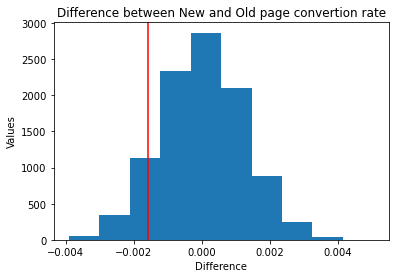

In [29]:
plt.hist(p_diffs)
plt.xlabel('Difference')
plt.ylabel('Values')
plt.title('Difference between New and Old page convertion rate')
plt.axvline(obs_diff,color='red');

In [30]:
p_diffs = np.array(p_diffs)

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
(p_diffs > obs_diff).mean()

0.9063

**Conclusion**
- This value we just calculated is called p-value and since it's much larger than type 1 error rate which is 0.05 so we can't reject the null hypothesis. 
- So we can say now that we should stick to our old page since we proved that there is a statistically significant evidenvce that the old page has higher conversion rate than the new page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [32]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[(df2['landing_page'] == 'old_page') & (df['converted'] == 1)].count()

# number of conversions with the new_page
convert_new = df2[(df2['landing_page'] == 'new_page') & (df['converted'] == 1)].count()

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == 'old_page'].count()

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == 'new_page'].count()

convert_old['user_id'] , convert_new['user_id'] , n_old['user_id'], n_new['user_id']

C:\Users\Eman Abd El-Hamied\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Eman Abd El-Hamied\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


(17489, 17264, 145274, 145310)

**m.** Now I'll use `sm.stats.proportions_ztest()` to compute my test statistic and p-value.  




The built-in function above will return the z_score, p_value. 


$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. I can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if my hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Info:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.


In [53]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_old['user_id'] , convert_new['user_id']] , [n_old['user_id'], n_new['user_id']], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>This results agree with our findings before, p-vlaue here is 0.905 which is more than the alpha level 0.05 so we can't reject the null hypothesis here. As we stated before we should stick to our old page and not convert to the new one. 


<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, I will see that the result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, I'll use Logestic Regression here.

Logestic Regression


**b.** The goal is to use **statsmodels** library to fit the regression model I specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, I first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.drop('control',axis=1,inplace=True)

In [35]:
df2.rename(columns = {'treatment':'ab_page'}, inplace = True)

In [36]:
df2['intercept'] = 1

**c.** Using **statsmodels** to instantiate my regression model on the two columns I created in part (b). above, then I'll fit the model to predict whether or not an individual converts. 


In [37]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Summary of my model below

In [38]:
results.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-01-13 15:15 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  
>
p-value associated with ab_page here is 0.1899 and it's greater than our alpha so we cannot reject the null hypothesis as before. p_value here differs from the value we calculated before because this is a two tailed test but before it was a one tailed test.

**f.** Now, I'm considering other things that might influence whether or not an individual converts.  We will discuss why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into my regression model?

>We sill discuss now wether the conversion rate is related to country or not. Adding more factors to my model gives us more insighgts about the users and if their behaviour is affected by anything else rather than the one we are testing for. 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Does it appear that country had an impact on conversion?  To answer this question, I'll consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

In [44]:
# Read the countries.csv
df_countries = pd.read_csv('D:/Machine_Learning/FWD/Advanced\Analyzing AB_Test_Results/analyzeabtestresults-2/AnalyzeABTestResults 2/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# Join with the df2 dataframe
df_countries = pd.merge(df2, df_countries, on='user_id', how='inner')

In [46]:
# Create the necessary dummy variables
df_countries[['UK','US','CA']] = pd.get_dummies(df_countries['country'])


In [47]:
df_countries['UK_ab_page'] = df_countries['UK'] * df_countries['ab_page']
df_countries['US_ab_page'] = df_countries['US'] * df_countries['ab_page']

In [48]:
df_countries.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,CA,UK_ab_page,US_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [50]:
logit_mod_countries = sm.Logit(df_countries['converted'],df_countries[['intercept', 'UK','US','UK_ab_page','US_ab_page']])

**h. Fitting my model and obtaining the results**<br> 
We would now like to look at an interaction between page and country to see if  there are significant effects on conversion. 
 


In [51]:
# Fit your model, and summarize the results
results_countries = logit_mod_countries.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [52]:
results_countries.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9259
Date:               2022-01-13 15:19 BIC:              212835.8241
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           4                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.27295    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
US            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
UK_ab_page   -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
US_ab_page    0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

>**Conclusion**
- P-Value for UK is 0.84 and for US is 0.79, UK_ab_page is 0.19 and US_ab_page is 0.63 all of them are greater than our alpha 0.05. 
- We can't reject our null hypothesis which states that countries don't have impact on our conversion rate. 
- As we stated before we now should get back to our old page as there is not enough evidence that the new page has a higher conversion rate.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])